In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.preprocessing import image
import time

In [11]:
# Reverse Augmentation
def reverse_sound(data, sr=22050):
    data_len = len(data)
    data = np.array([data[len(data)-1-i] for i in range(len(data))])
    return data

# Minus Augmentation
def minus_sound(data, sr=22050):
    temp_numpy = (-1)*data
    return temp_numpy

# White Noise Augmentation 0.003
def adding_white_noise1(data, noise_rate=0.003):
    wn = np.random.randn(len(data))
    data_wn = data + noise_rate * wn
    return data_wn

# White Noise Augmentation 0.005
def adding_white_noise2(data, noise_rate=0.005):
    wn = np.random.randn(len(data))
    data_wn = data + noise_rate * wn
    return data_wn

# White Noise Augmentation 0.007
def adding_white_noise3(data, noise_rate=0.007):
    wn = np.random.randn(len(data))
    data_wn = data + noise_rate * wn
    return data_wn

# Shift Augmentation
def shifting_sound(data, sr=22050, roll_rate=0.1):
    data_roll = np.roll(data, int(len(data) * roll_rate))
    return data_roll

def TFLiteInference(model_path, x_test, y_test, num_classes):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    
    sum_correct = 0.0
    sum_time = 0.0

    # 추가: Confusion matrix 초기화
    conf_mat = np.zeros((num_classes, num_classes), dtype=np.int32)

    for idx, data in enumerate(zip(x_test, y_test)):
        image = data[0]
        label = data[1]

        image = image.astype(np.float32)
        image = np.expand_dims(image, axis=0)
        
        s_time = time.time()
        interpreter.set_tensor(input_index, image)
        interpreter.invoke()
        pred = interpreter.get_tensor(output_index)
        
        sum_time += time.time() - s_time

        # 추가: Confusion matrix 갱신
        true_class = np.argmax(label)
        pred_class = np.argmax(pred)
        conf_mat[true_class, pred_class] += 1

        if pred_class == true_class:
            sum_correct += 1.0
            
    mean_acc = sum_correct / float(idx + 1)
    mean_time = sum_time / float(idx + 1)
    
    print(f'Accuracy of TFLite model: {mean_acc}')
    print(f'Inference time of TFLite model: {mean_time}')

    # 추가: Confusion matrix 출력
    print("Confusion Matrix:")
    print(conf_mat)

# 사용 예시
model_path = 'C:\\Users\\user\\Desktop\\TinyML\\model.tflite'
# x_test, y_test: 테스트 데이터
num_classes = 2

In [3]:
# audio_ok = "D:\\Dataset\\#1_Dataset_장비이상 조기탐지 AI 데이터셋#1\\data\\FAN_sound_OK"
# audio_er = "D:\\Dataset\\#1_Dataset_장비이상 조기탐지 AI 데이터셋#1\\data\\FAN_sound_error"

# output_ok = "C:\\Users\\user\\Desktop\\test\\Define\\Define_1_2\\okMel"
# output_er = "C:\\Users\\user\\Desktop\\test\\Define\\Define_1_2\\mel_spectrograms"

# os.makedirs(output_ok, exist_ok=True)
# os.makedirs(output_er, exist_ok=True)

# audio_files_ok = os.listdir(audio_ok)
# audio_files_er = os.listdir(audio_er)

# # # 각 오디오 파일에 대해 Mel 스펙트로그램을 계산하고 이미지로 저장
# # for audio_file in audio_files_ok:
# #     audio_path = os.path.join(audio_ok, audio_file)
# #     y, sr = librosa.load(audio_path)

# #     # Mel 스펙트로그램 계산
# #     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

# #     # Mel 스펙트로그램을 이미지로 변환
# #     mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
# #     mel_spectrogram_db_image = (mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min())  # 0~1로 스케일 조정

# #     # 이미지 파일로 저장
# #     output_file_path = os.path.join(output_ok, os.path.splitext(audio_file)[0] + ".png")
# #     plt.imsave(output_file_path, mel_spectrogram_db_image, cmap='viridis')
    
# #     # 각 오디오 파일에 대해 Mel 스펙트로그램을 계산하고 이미지로 저장
# # for audio_file in audio_files_er:
# #     audio_path = os.path.join(audio_er, audio_file)
# #     y, sr = librosa.load(audio_path)

# #     # Reverse Augmentation
# #     reversed_y = reverse_sound(y)

# #     # Minus Augmentation
# #     minus_y = minus_sound(y)
    
# #     #White Noise Augmentation
# #     addwn_y = adding_white_noise(y)
    
# #     #Shifting Augmentation
# #     shift_y = shifting_sound(y)
    
# #     augmentations = [y, reversed_y, minus_y, addwn_y, shift_y]

# #     for augmentation_index, augmented_y in enumerate(augmentations):
# #         mel_spectrogram = librosa.feature.melspectrogram(y=augmented_y, sr=sr)

# #         mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
# #         mel_spectrogram_db_image = (mel_spectrogram_db - mel_spectrogram_db.min()) / (mel_spectrogram_db.max() - mel_spectrogram_db.min())  # 0~1로 스케일 조정

# #         output_file_path = os.path.join(output_er, os.path.splitext(audio_file)[0] + f"_augmentation_{augmentation_index}.png")
# #         plt.imsave(output_file_path, mel_spectrogram_db_image, cmap='viridis')

In [4]:
output_ok = 'C:\\Users\\user\\Desktop\\test\\Define\\Define_1_2\\mfcc_ok'
output_er = 'C:\\Users\\user\\Desktop\\test\\Define\\Define_1_2\\mfcc_er'

x_ok_label = []
x_er_label = []
ok_image_paths = [os.path.join(output_ok, filename) for filename in os.listdir(output_ok) if filename.endswith(".png")]
er_image_paths = [os.path.join(output_er, filename) for filename in os.listdir(output_er) if filename.endswith(".png")]


for image_path in ok_image_paths:
 
    image = Image.open(image_path)

    image_array = np.array(image)
    x_ok_label.append(image_array)


for image_path in er_image_paths:

    image = Image.open(image_path)
    
    image_array = np.array(image)
    x_er_label.append(image_array)

x_ok_label = np.array(x_ok_label)
x_er_label = np.array(x_er_label)

print(x_ok_label.shape)
print(x_er_label.shape)

(170, 400, 1000, 4)
(196, 400, 1000, 4)


In [5]:
train_num_ok = 136
train_num_er = 167
test_num_ok = 34
test_num_er = 32

# 1
x_train = np.concatenate([x_ok_label[test_num_ok:], x_er_label[test_num_er:]], axis=0)
y_train = np.concatenate([np.zeros(train_num_ok), np.ones(train_num_er)], axis=0)
x_test = np.concatenate([x_ok_label[:test_num_ok], x_er_label[:test_num_er]], axis=0)
y_test = np.concatenate([np.zeros(test_num_ok), np.ones(test_num_er)], axis=0)

# # 2
# x_train = np.concatenate([x_ok_label[:test_num_ok],x_ok_label[2*test_num_ok:], x_er_label[:test_num_er], x_er_label[2*test_num_er:]], axis=0)
# y_train = np.concatenate([np.zeros(train_num_ok), np.ones(train_num_er)], axis=0)
# x_test = np.concatenate([x_ok_label[test_num_ok:2*test_num_ok], x_er_label[test_num_er:2*test_num_er]], axis=0)
# y_test = np.concatenate([np.zeros(test_num_ok), np.ones(test_num_er)], axis=0)

# # 3
# x_train = np.concatenate([x_ok_label[:2*test_num_ok],x_ok_label[3*test_num_ok:], x_er_label[:2*test_num_er], x_er_label[3*test_num_er:]], axis=0)
# y_train = np.concatenate([np.zeros(train_num_ok), np.ones(train_num_er)], axis=0)
# x_test = np.concatenate([x_ok_label[2*test_num_ok:3*test_num_ok], x_er_label[2*test_num_er:3*test_num_er]], axis=0)
# y_test = np.concatenate([np.zeros(test_num_ok), np.ones(test_num_er)], axis=0)

# # 4
# x_train = np.concatenate([x_ok_label[:3*test_num_ok],x_ok_label[4*test_num_ok:], x_er_label[:3*test_num_er], x_er_label[4*test_num_er:]], axis=0)
# y_train = np.concatenate([np.zeros(train_num_ok), np.ones(train_num_er)], axis=0)
# x_test = np.concatenate([x_ok_label[3*test_num_ok:4*test_num_ok], x_er_label[3*test_num_er:4*test_num_er]], axis=0)
# y_test = np.concatenate([np.zeros(test_num_ok), np.ones(test_num_er)], axis=0)

# # 5
# x_train = np.concatenate([x_ok_label[:train_num_ok], x_er_label[:train_num_er]], axis=0)
# y_train = np.concatenate([np.zeros(train_num_ok), np.ones(train_num_er)], axis=0)
# x_test = np.concatenate([x_ok_label[train_num_ok:], x_er_label[train_num_er:]], axis=0)
# y_test = np.concatenate([np.zeros(test_num_ok), np.ones(test_num_er)], axis=0)

print(x_train.shape, x_test.shape)
print(y_test)

x_valid = x_test
y_valid = y_test

(300, 400, 1000, 4) (66, 400, 1000, 4)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
train_num = len(x_train)
test_num = len(x_test)
train_indices = np.arange(train_num)
test_indices = np.arange(test_num)

np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

x_train = x_train[train_indices]
y_train = y_train[train_indices]
x_test = x_test[test_indices]
y_test = y_test[test_indices]

num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# train_num = len(x_train)
# valid_num = len(x_valid)
# test_num = len(x_test)
# train_indices = np.arange(train_num)
# valid_indices = np.arange(valid_num)
# test_indices = np.arange(test_num)

# np.random.shuffle(train_indices)
# np.random.shuffle(test_indices)
# np.random.shuffle(valid_indices)

# x_train = x_train[train_indices]
# y_train = y_train[train_indices]
# x_valid = x_valid[valid_indices]
# y_valid = y_valid[valid_indices]
# x_test = x_test[test_indices]
# y_test = y_test[test_indices]

# num_classes = 2

# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_valid = keras.utils.to_categorical(y_valid, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
def shallow_convolutional_model():   
    model = Sequential()
    model.add(Conv2D(16, (3, 3), strides=(1, 1), activation='relu', input_shape=(400, 1000, 4)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def deep_convolutional_model():
    model = Sequential()
    # model.add(Conv2D(16, (3, 3), strides=(1, 1), activation='relu', input_shape=(600, 1000, 4)))
    model.add(Conv2D(16, (3, 3), strides=(1, 1), activation='relu', input_shape=(400, 1000, 4)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    # model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
    # model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

    
model = deep_convolutional_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 998, 16)      592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 499, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 497, 32)      4640      
                                                                 
 average_pooling2d (AverageP  (None, 98, 248, 32)      0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 777728)            0         
                                                                 
 dense (Dense)               (None, 100)               7

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=16)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Epoch 1/20
19/19 [==============================] - 12s 593ms/step - loss: 10666.5479 - accuracy: 0.4767
Epoch 2/20
19/19 [==============================] - 11s 580ms/step - loss: 137.5459 - accuracy: 0.4967
Epoch 3/20
19/19 [==============================] - 11s 582ms/step - loss: 15.5632 - accuracy: 0.5833
Epoch 4/20
19/19 [==============================] - 11s 584ms/step - loss: 0.8115 - accuracy: 0.5267
Epoch 5/20
19/19 [==============================] - 11s 583ms/step - loss: 0.5650 - accuracy: 0.6300
Epoch 6/20
19/19 [==============================] - 11s 583ms/step - loss: 0.3358 - accuracy: 0.9367
Epoch 7/20
19/19 [==============================] - 11s 582ms/step - loss: 0.3184 - accuracy: 0.9600
Epoch 8/20
19/19 [==============================] - 11s 582ms/step - loss: 0.3030 - accuracy: 0.9733
Epoch 9/20
19/19 [==============================] - 11s 583ms/step - loss: 0.2934 - accuracy: 0.9833
Epoch 10/20
19/19 [==============================] - 11s 603ms/step - loss: 0.2858 -

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpx2bcsur5\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpx2bcsur5\assets


In [9]:
start_time = time.time()
test_loss, test_accuracy = model.evaluate(x_test, y_test)
end_time = time.time()
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
training_time = end_time - start_time
print(f"Detecting time: {training_time} seconds")

3/3 [==============================] - 1s 120ms/step - loss: 0.2548 - accuracy: 1.0000
Test Loss: 0.2547643482685089, Test Accuracy: 1.0
Detecting time: 0.6249997615814209 seconds


In [12]:
TFLiteInference("C:\\Users\\user\\Desktop\\test\\Define\\Define_1_2\\model.tflite",x_test,y_test)

TypeError: TFLiteInference() missing 1 required positional argument: 'num_classes'

2/2 [==============================] - 1s 246ms/step
acc
0.9844
sen
0.9844
spe
0.9844
prc
0.9844
[[63  1]
 [ 1 63]]
Confusion Matrix:
[[0.9844 0.0156]
 [0.0156 0.9844]]


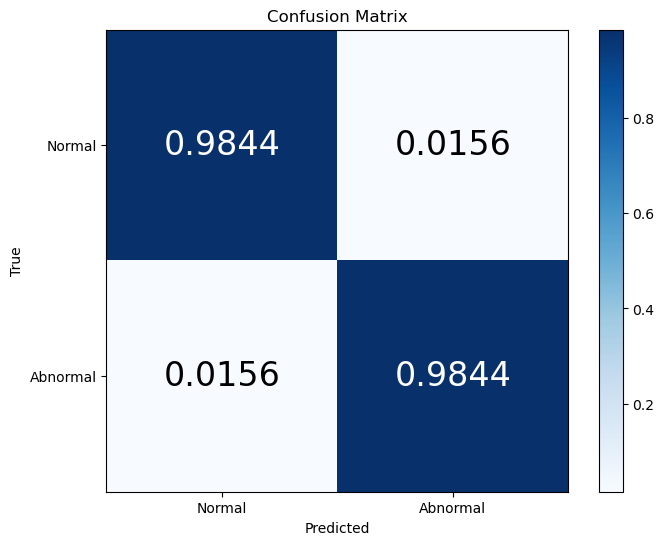

In [ ]:
# y_pred = model.predict(x_test)
# y_pred = (y_pred > 0.5)  

# print(y_test)

# error_count = 0



# for i in range(64):
#     if (y_test[i][0]==1.0)and(y_pred[i][0]==True):
#         true_positive += 1
#     elif (y_test[i][0]==0)and(y_pred[i][0]==True):
#         false_positive += 1
#     elif (y_test[i][0]==1.0)and(y_pred[i][0]==False):
#         false_negative += 1
#     elif (y_test[i][0]==0)and(y_pred[i][0]==False):
#         true_negative += 1
#     else:
#         error_count += 1


# print(y_test)        
# # if true_positive == 0 :
# #     true_positive = 1
    
# # if false_positive == 0 :
# #     false_positive = 1
    
# # if true_negative == 0 :
# #     true_negative = 1
    
# # if false_negative == 0 :
# #     false_negative = 1

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0

total_positive = true_positive+false_negative
total_negative = true_negative+false_positive

total = total_positive+total_negative ## 전체

print(true_positive, false_positive, false_negative, true_negative) 

# confusion_matrix = np.array([[round(true_positive/total_positive,6), round(false_positive/total_negative,6)],
#                              [round(false_negative/total_positive,6), round(true_negative/total_negative,6)]]) #TP ,FP , FN, TN

confusion_matrix = np.array([[true_positive,false_positive],
                             [false_negative,true_negative]]) 



Accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
print(Accuracy)

print(confusion_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Abnormal'])
plt.yticks([0, 1], ['Normal', 'Abnormal'])
plt.xlabel('True')
plt.ylabel('Predicted')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color='black', fontsize=18)
plt.show()

0 0 0 0


ZeroDivisionError: division by zero

In [ ]:

total_positive = true_positive+false_negative #수정
total_negative = true_negative+false_positive #수정

print("acc")
print(round((true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative),4))
print("sen")
print(round(true_positive/(true_positive+false_negative),4))
print("spe")
print(round(true_negative/(true_negative+false_positive),4))
print("prc")
print(round(true_positive/(true_positive+false_positive),4))


confusion_matrix = np.array([[round(true_positive/total_positive,4), round(false_positive/total_negative,4)],
                             [round(false_negative/total_positive,4), round(true_negative/total_negative,4)]])

print("Confusion Matrix:")
print(confusion_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Normal', 'Abnormal'], fontsize=20)
plt.yticks([0, 1], ['Normal', 'Abnormal'], fontsize=20)
plt.xlabel('True', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.text(0, 0, str(confusion_matrix[0, 0]), ha='center', va='center', color='white', fontsize=24)
plt.text(1, 0, str(confusion_matrix[0, 1]), ha='center', va='center', color='black', fontsize=24)
plt.text(0, 1, str(confusion_matrix[1, 0]), ha='center', va='center', color='black', fontsize=24)
plt.text(1, 1, str(confusion_matrix[1, 1]), ha='center', va='center', color='white', fontsize=24)
plt.show()


acc


ZeroDivisionError: division by zero

acc
0.8998
f1 score
0.9305
recall
0.8704
Confusion Matrix:
[[0.8704 0.0014]
 [0.1296 0.9986]]


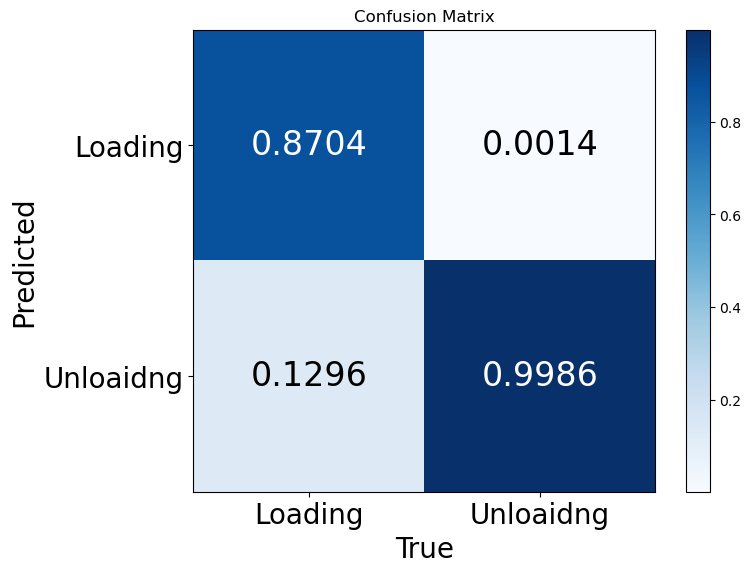

In [ ]:
true_positive = 23173   
true_negative = 7925
false_positive = 11
false_negative = 3451
         
P = true_positive+false_negative 
N = true_negative+false_positive 
PP = true_positive+false_positive
PN = false_negative+true_negative

print("acc")
print(round(((true_positive+true_negative)/(P+N)),4))
print("f1 score")
print(round(((2*true_positive)/(2*true_positive+false_positive+false_negative)),4))
print("recall")
print(round((true_positive)/(P),4))


confusion_matrix = np.array([[round(true_positive/P,4), round(false_positive/N,4)],
                             [round(false_negative/P,4), round(true_negative/N,4)]])

print("Confusion Matrix:")
print(confusion_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Loading', 'Unloaidng'], fontsize=20)
plt.yticks([0, 1], ['Loading', 'Unloaidng'], fontsize=20)
plt.xlabel('True', fontsize=20)
plt.ylabel('Predicted', fontsize=20)
plt.text(0, 0, str(confusion_matrix[0, 0]), ha='center', va='center', color='white', fontsize=24)
plt.text(1, 0, str(confusion_matrix[0, 1]), ha='center', va='center', color='black', fontsize=24)
plt.text(0, 1, str(confusion_matrix[1, 0]), ha='center', va='center', color='black', fontsize=24)
plt.text(1, 1, str(confusion_matrix[1, 1]), ha='center', va='center', color='white', fontsize=24)
plt.show()